# January 2021

## Table of Contents <a id=toc></a>

1. [Problem Statement](#prblm-statement)
2. [Exploratory Data Analysis](#eda)
3. [Feature Selection](#feature-selection)
4. [Modelling](#modelling)
    1. [Linear Regression](#linear-regression)
    2. [SGD Regressor](#sgd)
        1. [Predictions on Test Data w/o tuning](#predictions-sgd-no-tuning)
        2. [Hyperparameter Tuning](#tuning-sgd)
            1. [Random Search](#sgd-random-search)
            2. [Grid Search](#sgd-grid-search)

# [1. Problem Statement](#toc) <a id=prblm-statement></a>

The goal is to predict a continuous `target` given a set of continuous features.

Since the `target` variable is continuous, this can be treated as a regression problem.

In [1]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# my functions
from functions.data_exploration import basic_eda

In [2]:
# importing the data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# X/y split
X = train_df.drop(["id","target"], axis=1)
y = train_df['target']

# [2. Exploratory Data Analysis](#toc) <a id=eda></a>

In [3]:
# looking at what each of the columns are and their data types
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


From the above, it can be seen that there are 15 features and 300,000 training samples. Furthermore, there seems to be no missing data and all the data types are numerical in nature.

In [4]:
# basic look at the descriptive statistics of the data
train_df.describe().round(3)

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000,300000.000
mean,249825.146,0.507,0.498,0.522,0.516,0.502,0.527,0.488,0.525,0.460,0.521,0.484,0.507,0.553,0.504,7.906
std,144476.733,0.204,0.228,0.201,0.233,0.221,0.218,0.181,0.216,0.197,0.202,0.220,0.219,0.230,0.208,0.733
min,1.000,-0.082,-0.031,0.021,0.153,0.276,0.066,-0.098,0.217,-0.241,-0.085,0.083,0.089,0.030,0.166,0.000
25%,124656.500,0.343,0.319,0.344,0.295,0.284,0.356,0.347,0.341,0.331,0.375,0.300,0.310,0.350,0.309,7.329
50%,249738.500,0.484,0.553,0.551,0.483,0.452,0.471,0.467,0.483,0.417,0.459,0.442,0.487,0.488,0.432,7.941
75%,374836.250,0.644,0.731,0.648,0.749,0.671,0.694,0.581,0.685,0.575,0.700,0.679,0.694,0.768,0.713,8.470
max,499999.000,1.016,0.860,1.007,1.010,1.034,1.044,1.066,1.024,1.004,1.200,1.023,1.049,0.978,0.869,10.268


There seems to be no need for scaling since the maximum and minimum values of all the features (except `id`) are more or less between 0 and 1.

In [5]:
# looking at the correlation b/w each of the features and the target
corr = X.corrwith(y)
corr

cont1    -0.032994
cont2     0.067102
cont3     0.058936
cont4     0.005522
cont5    -0.005358
cont6     0.027955
cont7     0.067234
cont8     0.014698
cont9    -0.013029
cont10   -0.021143
cont11    0.050996
cont12    0.047809
cont13   -0.006642
cont14   -0.006609
dtype: float64

In [6]:
# highest positive correlation value
corr.max()

0.06723394722080096

In [7]:
# highest negative correlation value
corr.min()

-0.032993698537688285

Due to the fact that the highest of both positive and negative correlation between the various features and the target is only $0.067$, we can assume that a **linear regression model** would vastly **underfit** the data.

In [9]:
# the correlation between the various features themselves
corr_mat = X.corr()
corr_mat

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
cont1,1.000000,-0.080170,-0.419712,0.273705,-0.059012,0.698556,0.341478,0.373340,0.794003,0.725040,0.565717,0.600041,0.570382,0.067294
cont2,-0.080170,1.000000,0.334487,-0.005533,0.150737,0.023692,0.116222,0.081049,-0.046769,0.035101,0.126024,0.092642,0.017383,0.023972
cont3,-0.419712,0.334487,1.000000,-0.329131,0.060931,-0.300509,0.106904,-0.309783,-0.406743,-0.289756,-0.075415,-0.103735,-0.386521,-0.065457
cont4,0.273705,-0.005533,-0.329131,1.000000,0.123526,0.152752,-0.077045,0.324784,0.261927,0.204139,0.063961,0.073291,0.155226,0.054703
cont5,-0.059012,0.150737,0.060931,0.123526,1.000000,-0.179084,-0.241272,0.010438,-0.071764,-0.102531,-0.222244,-0.192571,-0.140272,0.040552
cont6,0.698556,0.023692,-0.300509,0.152752,-0.179084,1.000000,0.541975,0.415008,0.716613,0.770628,0.737495,0.757105,0.783604,0.067007
cont7,0.341478,0.116222,0.106904,-0.077045,-0.241272,0.541975,1.000000,0.150403,0.341759,0.465418,0.672188,0.657310,0.322415,-0.037135
cont8,0.373340,0.081049,-0.309783,0.324784,0.010438,0.415008,0.150403,1.000000,0.429986,0.362336,0.296598,0.323042,0.475072,0.100645
cont9,0.794003,-0.046769,-0.406743,0.261927,-0.071764,0.716613,0.341759,0.429986,1.000000,0.725053,0.575095,0.605091,0.628391,0.081992
cont10,0.725040,0.035101,-0.289756,0.204139,-0.102531,0.770628,0.465418,0.362336,0.725053,1.000000,0.677570,0.701872,0.650809,0.047727


In [10]:
# finding the variables that are have at least a correlation coefficient of 0.5
corr_mat[corr_mat > 0.5]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
cont1,1.000000,NaN,NaN,NaN,NaN,0.698556,NaN,NaN,0.794003,0.725040,0.565717,0.600041,0.570382,NaN
cont2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont6,0.698556,NaN,NaN,NaN,NaN,1.000000,0.541975,NaN,0.716613,0.770628,0.737495,0.757105,0.783604,NaN
cont7,NaN,NaN,NaN,NaN,NaN,0.541975,1.000000,NaN,NaN,NaN,0.672188,0.657310,NaN,NaN
cont8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
cont9,0.794003,NaN,NaN,NaN,NaN,0.716613,NaN,NaN,1.000000,0.725053,0.575095,0.605091,0.628391,NaN
cont10,0.725040,NaN,NaN,NaN,NaN,0.770628,NaN,NaN,0.725053,1.000000,0.677570,0.701872,0.650809,NaN


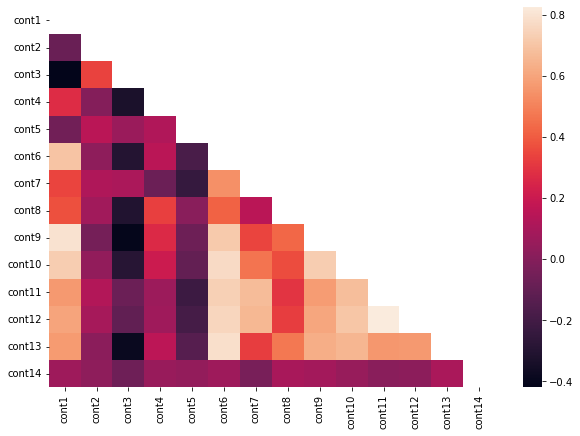

In [11]:
# heatmap of correlation matrix
basic_eda.corr_heatmap(corr_mat)

Since there are a few features that are highly correlated with each other (correlation coefficient greater than 0.5), there is scope for feature reduction based on the correlation.

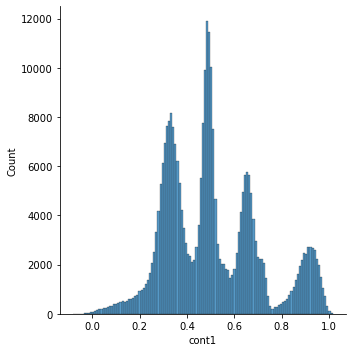

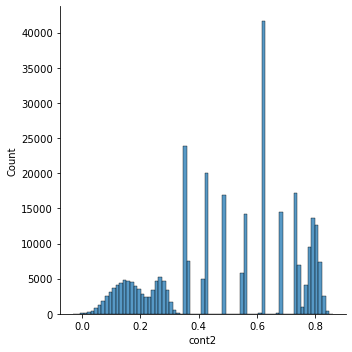

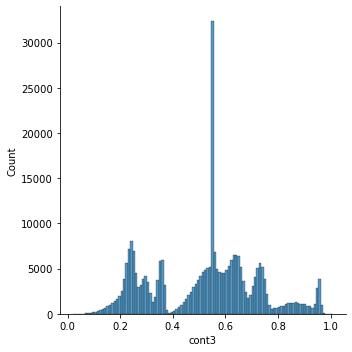

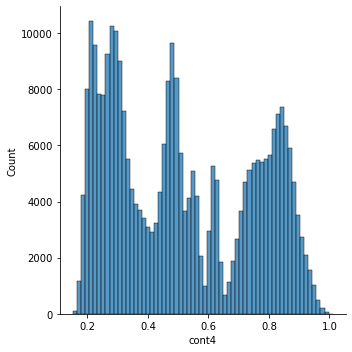

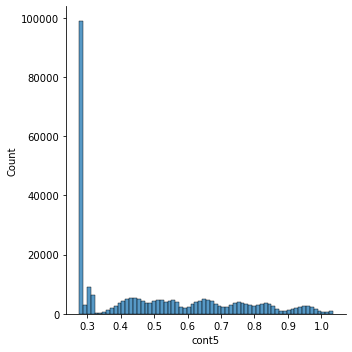

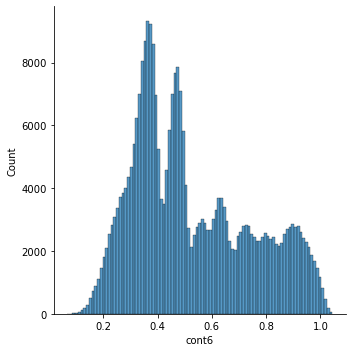

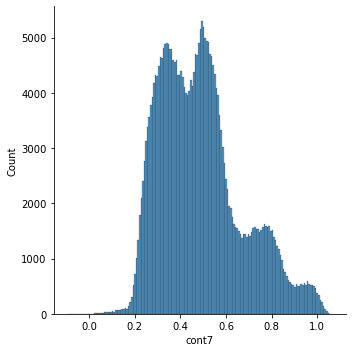

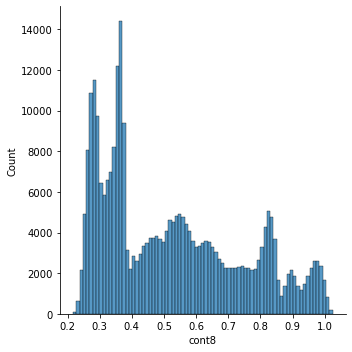

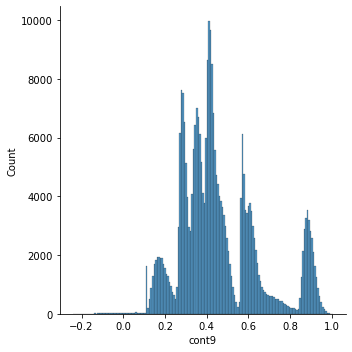

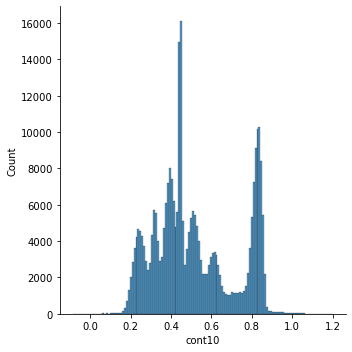

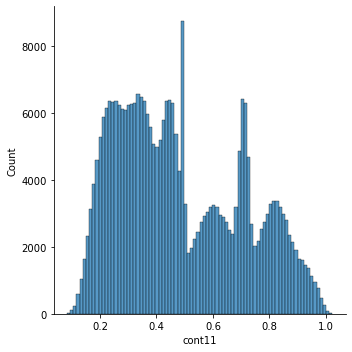

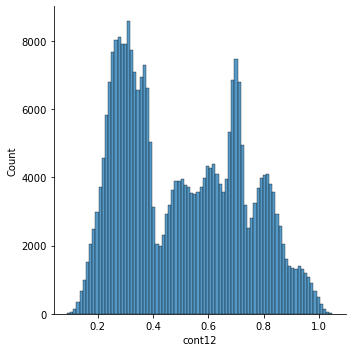

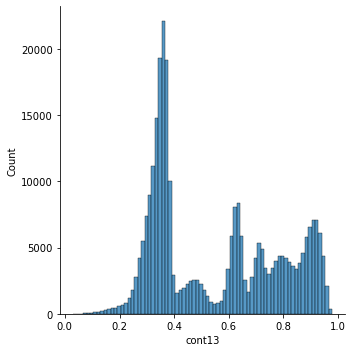

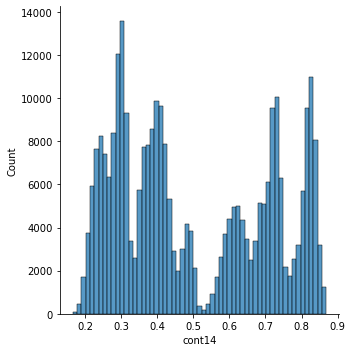

In [12]:
# distributions of all the features
for col in list(X.columns):
    sns.displot(X[col])
    plt.show()

The features all have skewed distributions, so we should normalize them before training the models.

# [3. Data Preprocessing](#toc) <a id=preprocessing></a>

In [14]:
# train/validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

In [15]:
# normalizing the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# [4. Modelling](#toc) <a id=modelling></a>

## [4.1 Linear Regression](#toc) <a id=linear-regression></a>

From the correlation coefficients with respect to the target, we could assume that a linear regression model would not be very effective, but just fitting a simple linear regression model to confirm the assumption.

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_val, y_val)

0.018123555250413648

As seen, the linear regression model performs poorly on the validation set.

## [4.2 SGD Regressor](#toc) <a id=sgd></a>

The penalty will be `l1 norm` which will have an effect of feature selection due to the coefficients of some features potentially becoming 0.

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

sgd_reg = SGDRegressor(penalty='l1')
scorer = make_scorer(mean_squared_error)
cv_scores = cross_validate(
    sgd_reg,
    X_train,
    y_train,
    cv=5,
    scoring=scorer,
)

In [18]:
# average RMSE based on 5-fold cross validation
np.sqrt(cv_scores['test_score']).mean().round(3)

0.728

In [19]:
# fitting the model on the training data
sgd_reg.fit(X_train, y_train);

# scoring the model on the validation set
y_val_preds = sgd_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_preds))

0.7258917095949289

### [4.2.1 Predictions on Test Data w/o tuning](#toc) <a id=predictions-sgd-no-tuning></a>

In [20]:
X_test = test_df.drop("id", axis=1)
y_preds = sgd_reg.predict(X_test)

submit_data = {
    'id': test_df['id'],
    'target': y_preds,
}
submission_df = pd.DataFrame(submit_data)
submission_df.to_csv("submissions/submit_1_sgd.csv", index=False)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


### [4.2.2 Hyperparameter Tuning](#toc) <a id=tuning-sgd></a>

In [21]:
sgd_reg = SGDRegressor()
params = {
    "penalty": ["l2", "elasticnet", "l1"],
    "l1_ratio": [0.1, 0.15, 0.2],
    "max_iter": [1000, 1200, 1400],
    "learning_rate": ['constant', 'optimal', 'invscaling'],
    "warm_start": ["True", "False"],
}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#### [4.2.2.1 RandomSearch](#toc) <a id=sgd-random-search></a>

In [22]:
from sklearn.model_selection import RandomizedSearchCV

rs_reg = RandomizedSearchCV(
    sgd_reg,
    params,
    n_iter = 50,
    scoring=scorer,
    cv=5,
)
rs_reg.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SGDRegressor(), n_iter=50,
                   param_distributions={'l1_ratio': [0.1, 0.15, 0.2],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling'],
                                        'max_iter': [1000, 1200, 1400],
                                        'penalty': ['l2', 'elasticnet', 'l1'],
                                        'warm_start': ['True', 'False']},
                   scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [23]:
# finding the best parameters from RandomizedSearch
rs_reg.best_params_

{'warm_start': 'False',
 'penalty': 'elasticnet',
 'max_iter': 1000,
 'learning_rate': 'invscaling',
 'l1_ratio': 0.1}

In [24]:
# scoring the best model (from RandomizedSearchCV) on the validation set
y_val_preds = rs_reg.best_estimator_.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_preds))

0.7255166649133273

#### [4.2.2.2 GridSearchCV](#toc) <a id=sgd-grid-search></a>

In [25]:
from sklearn.model_selection import GridSearchCV

sgd_reg = SGDRegressor()

grid_params = {
    "penalty": ["l1", "elasticnet"],
    "l1_ratio": [0.1, 0.15, 0.2],
    "max_iter": [1400, 1600],
    "learning_rate": ["optimal", 'invscaling'],
    "warm_start": ["True"],
    
}

gs_reg = GridSearchCV(
    sgd_reg,
    grid_params,
    cv=5,
    scoring=scorer,
)
gs_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(),
             param_grid={'l1_ratio': [0.1, 0.15, 0.2],
                         'learning_rate': ['optimal', 'invscaling'],
                         'max_iter': [1400, 1600],
                         'penalty': ['l1', 'elasticnet'],
                         'warm_start': ['True']},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [26]:
# best parameters
gs_reg.best_params_

{'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'max_iter': 1600,
 'penalty': 'l1',
 'warm_start': 'True'}

In [27]:
# score on validation set
y_val_preds = gs_reg.best_estimator_.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_preds))

0.725655742035711

The model just doesn't seem to be performing all that better than the baseline model even when subject to hyperparameter tuning.

In [53]:
# fitting the model on the entire training data with the best parameters
sgd_reg_best = SGDRegressor(penalty='l1', warm_start=True, max_iter=1600, learning_rate='invscaling')
X_scaled = scaler.fit_transform(X)
sgd_reg_best.fit(X_scaled, y);

In [54]:
# predicting on the test data
X_test = test_df.drop("id", axis=1)
X_test_scaled = scaler.transform(X_test)
y_test_preds = sgd_reg_best.predict(X_test)

submit_data = {
    "id": test_df['id'],
    "target": y_test_preds,
}

submit_df = pd.DataFrame(submit_data)
submit_df.to_csv("submissions/submit_2_sgd_tuned.csv", index=False)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


## [4.3 Lasso Regression](#toc) <a id=lasso></a>

By using the `LassoCV()`, the hyperparameter tuning is essentially done automatically by `scikit-learn`.

In [43]:
from sklearn.linear_model import LassoCV

# instantiating model object
lasso_reg = LassoCV(cv=5)

# fitting the model
lasso_reg.fit(X_train, y_train)

# scoring model on validation set
y_val_preds = lasso_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_val_preds))

0.7252786710777028

# [5. Conclusion](#toc) <a id=conclusion></a>

The best performing model on the test data on Kaggle was the baseline model. It had a score of 0.7271. 

# [6. Way Forward](#toc) <a id=way-forward></a>

None of these models seem to be improving the performance of the model. The potential steps that can be taken to improve the model are:
* feature reduction to deal with multicollinearity between the various features
* try more complex models such as LGBM and XGBoost 